In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import TruncatedSVD

## Leemos los datos y los ordenamos por red social

Este dataset contiene 3 usuarios por político, donde cada usuario es una fila y en el campo AllText se encuentra el texto de los todos los posteos emitidos por dicho usuario en 2020 concatenados mediante un espacio en blanco. 

Para mas información sobre el dataset ir al paper.

In [2]:
usuarios = pd.read_csv("datasets/politicos2020_3redes.csv")
usuarios.shape

(150, 16)

In [3]:
#Reordeno por lado y por redSocial
usuarios = usuarios.sort_values('redSocial', ascending=[True])

## Sanitizamos los textos de los posteos

In [9]:
import re

texts = list(usuarios.AllText)
remuve1 = r'\bCambiar la configuración Ver' #saco esta frase que se repite mucho
remuve2 = r'\b\xa0mil'  #saco esta palabra
remuve3 = r'\breproducciones'  #saco esta palabra
remuve4 = r"\d\:|\.\d|:\d|\d"  #saco los numeros
remuve5 = r'http\S+'   #saco las urls
remuve6 = r'http\:\/\/.*?(?=\s)'   #saco las urls
remuve7 = r'\w+\.com\s?'  #saco las urls
remove8= r'\babro hilo\b' #saco la frase "abro hilo"
remove9= r'\bhilo\b' #saco la palabra "hilo"
remove10= r'(@[A-Za-z0-9]+)' #saco el resto de los arrobas

texts = [re.sub(remuve1 + '|' + remuve2 + '|' + remuve3 + '|' + remuve4 + '|' + remuve5 + '|' + remuve6 + '|' + remuve7+'|'+ remove8 + '|' + remove9 + '|' + remove10  , '', t) for t in texts]
texts2 = list(texts)

## Transformamos los textos en vectores TF-IDF

In [10]:
texts2 = list(texts)

# Cuento los terminos
count_vect = CountVectorizer(ngram_range = (1,3), max_df = 0.8, min_df = 0.01, stop_words=stopwords.words('spanish'), lowercase=True)
x_counts = count_vect.fit_transform(texts2)

In [11]:
# Genero matriz con valorizacion tf-idf
tfidf_transformer = TfidfTransformer(norm = 'l2')
x_tfidf = tfidf_transformer.fit_transform(x_counts)

## Identifico las 100 distribuciones principales de palabras

In [12]:
svd = TruncatedSVD(n_components=100, n_iter=200, random_state=42)
svd.fit(x_tfidf)


TruncatedSVD(n_components=100, n_iter=200, random_state=42)

In [13]:
trans = svd.transform(x_tfidf)
trans.shape

(150, 100)

# Entrenamiento del Árbol de decisión

## Separo los datos en train y test 

In [14]:
fb = [1]*50
ig = [1]*50
tw = [2]*50
y = np.concatenate((fb, ig,tw))
X_train, X_test, y_train, y_test = train_test_split(trans, y, random_state=42)

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
params = {
    'max_depth': np.arange(2, 20),
    'criterion': ["gini", "entropy"]
}

clf = DecisionTreeClassifier(random_state=42)

gscv1 = GridSearchCV(
    clf, params, scoring='roc_auc', n_jobs=-1, verbose=3,cv=5, return_train_score=True
).fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 157 out of 180 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.0s finished


## Calculo el ROC AUC

In [16]:
roc_auc_score(y_test, gscv1.predict_proba(X_test)[:, 1])

0.8814102564102564

## Función para graficar la matriz de confusión sobre las predicciones del árbol

In [17]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


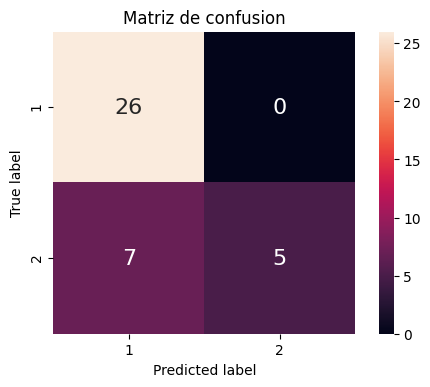

In [18]:
plot_confusion_matrix(y_test, gscv1.predict(X_test))

## Dibujo la estructura del árbol

In [19]:
# !pip install pydotplus
# También instalar Graphviz. (en ubuntu: sudo apt-get install graphviz)

from six import StringIO  
from IPython.display import Image, display
import pydotplus
import sklearn 

def dibujar_arbol(modelo,target_names,feature_names):
    dot_data = StringIO()
    sklearn.tree.export_graphviz(modelo, out_file=dot_data,  
                    filled=True, 
                    class_names = target_names,
                    feature_names=feature_names,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    display(Image(graph.create_png()))

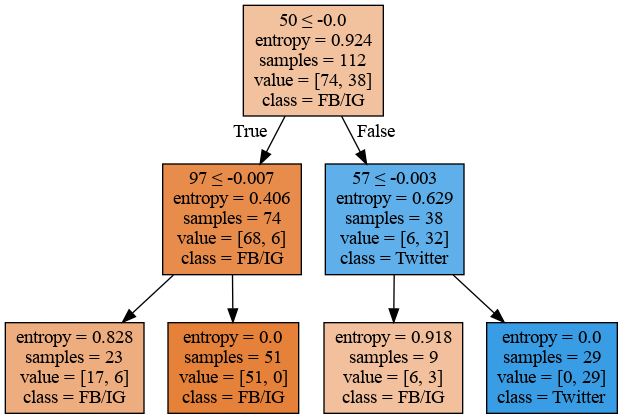

In [20]:
dibujar_arbol(gscv1.best_estimator_,['FB/IG','Twitter'],range(0,100))

## Topico 50

Identificamos las principales palabras de este tópico

In [58]:
vocab = vect.get_feature_names()
components = [svd.components_[i] for i in range(len(svd.components_))]

vocab_comp = zip(vocab, components[50])
sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:20]
#print("Topic "+str(50)+": ")
scores=[]
words=[]
for t in sorted_words:
    #print(t[0],t[1],end=" ")
    scores.append(t[1])
    words.append(t[0])
d = {'score':scores,'word':words}
words_scores_50_2 = pd.DataFrame(data=d)
words_scores_50_2[['word','score']]

,word,score
0,usted,0.151495
1,renuncia,0.101333
2,saludos,0.096966
3,buen día,0.079517
4,espalda,0.076991
5,acompañan siempre,0.067940
6,corrientes,0.067870
7,estudie,0.065661
8,comisión debía,0.064715
9,comisión debía expedirse,0.064715


## Distribución de scores por usuario sobre el tópico 50

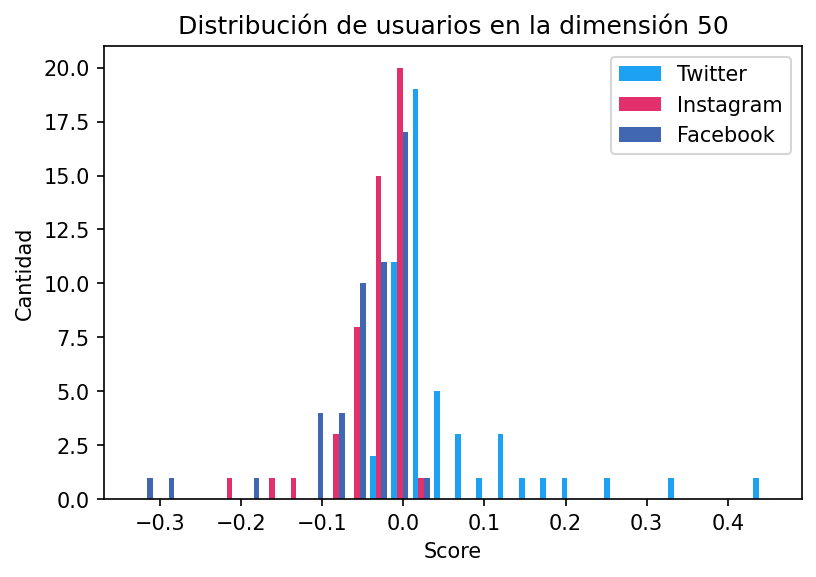

In [37]:
tw_u = usuarios[usuarios['redSocial']=='tw']
fb_u = usuarios[usuarios['redSocial']=='fb']
ig_u = usuarios[usuarios['redSocial']=='ig']

plt.figure(dpi=150)

plt.hist([tw_u['topico50'].values,fb_u['topico50'].values,ig_u['topico50'].values], 30, histtype='bar',color = ["#1DA1F2","#E1306C", "#4267B2",])
plt.title("Distribución de usuarios en la dimensión 50")
plt.xlabel("Score")
plt.ylabel("Cantidad")
plt.legend([ "Twitter","Instagram","Facebook"])
plt.savefig('Histograma 2 topico 50.png')
plt.show()

## Análisis importancia tokens

### Sanitizo sin eliminar las menciones a los usuarios

In [36]:
import re

texts = list(usuarios.AllText)
remuve1 = r'\bCambiar la configuración Ver' #saco esta frase que se repite mucho
remuve2 = r'\b\xa0mil'  #saco esta palabra
remuve3 = r'\breproducciones'  #saco esta palabra
remuve4 = r"\d\:|\.\d|:\d|\d"  #saco los numeros
remuve5 = r'http\S+'   #saco las urls
remuve6 = r'http\:\/\/.*?(?=\s)'   #saco las urls
remuve7 = r'\w+\.com\s?'  #saco las urls
remove8= r'\babro hilo\b' #saco la frase "abro hilo"
remove9= r'\bhilo\b' #saco la palabra "hilo"


texts = [re.sub(remuve1 + '|' + remuve2 + '|' + remuve3 + '|' + remuve4 + '|' + remuve5 + '|' + remuve6 + '|' + remuve7+'|'+ remove8 + '|' + remove9 , '', t) for t in texts]
texts2 = list(texts)

In [37]:
texts2 = list(texts)

# Cuento los terminos
count_vect = CountVectorizer(ngram_range = (1,3), max_df = 0.8, min_df = 0.01, stop_words=stopwords.words('spanish'), lowercase=True)
x_counts = count_vect.fit_transform(texts2)

#### Calculo los coeficientes

In [38]:
import numpy as np
coefficients1 = np.sum(x_counts.toarray()[usuarios['redSocial']=='tw'], axis=0)
coefficients2 = np.sum(x_counts.toarray()[usuarios['redSocial']!='tw'], axis=0)
coefficients1 = np.interp(coefficients1, (coefficients1.min(), coefficients1.max()), (0, +1))
coefficients2 = np.interp(coefficients2, (coefficients2.min(), coefficients2.max()), (0, +1))


### Grafico


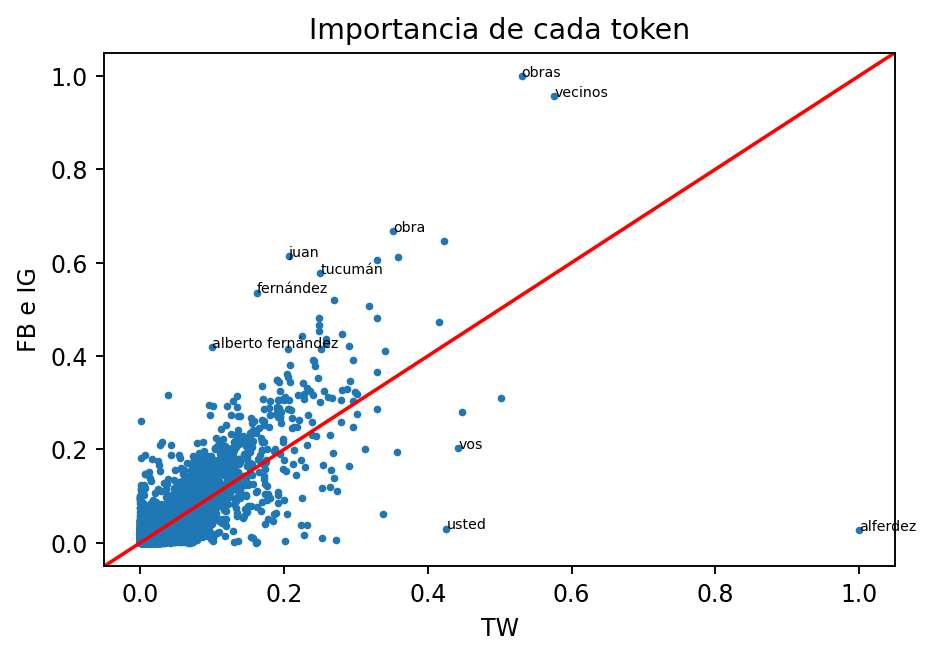

In [43]:
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
fig, ax = plt.subplots(dpi=(170))
ax.scatter(coefficients1, coefficients2, s=5)
for i, txt in enumerate(count_vect.get_feature_names()):
    if( (coefficients1[i] -0.36 > coefficients2[i]) or (coefficients1[i] < coefficients2[i] -0.3)  or txt=='alferdez' or txt=='vos'):
        ax.annotate(txt, (coefficients1[i], coefficients2[i]), fontsize=6)
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.ylabel("FB e IG")
plt.xlabel("TW")
plt.title('Importancia de cada token')
plt.savefig('importancia_token_por_red.png')
plt.show()
